# Figures

## Coverage depth analysis

In [1]:
import pandas as pd
from common import *

prom_raw = readModbam2bed("/mnt/data1/doh28/data/prom_R10.4.1_E8.2_WGS_brain_DH/dorado_0.3.2_basecalls/cbm1_prom_modbases_mapq60.bed", 1)

In [2]:
oxbs_raw = readBismarkZeroCov("/mnt/data1/doh28/data/CRR008808_oxBS/extraction_output/mapq_filter/CRR008808_oxBS_merged.bedGraph.gz.bismark.zero.cov", "5mC", 1)
tab_raw = readBismarkZeroCov("/mnt/data1/doh28/data/CRR008807_TAB/mapq_filtered/modified_bases/CRR008807_TAB_merged_resorted_q10.bedGraph.gz.bismark.zero.cov", "5hmC", 1)

In [3]:
all_raw = pd.merge(tab_raw, oxbs_raw, "inner", ["chromosome", "chromStart", "chromEnd"], suffixes=["_TAB", "_oxBS"]).merge(
    prom_raw, "inner", ["chromosome", "chromStart", "chromEnd"], suffixes=["_Bisulphite", "_Prom"])

In [4]:
readcounts_only = all_raw.drop(columns=["percentMeth_5hmC_Bisulphite", "percentMeth_5mC_Bisulphite", "strand", "percentMeth_C", "percentMeth_5mC_Prom", "percentMeth_5hmC_Prom"]).rename(columns={
    "readCount" : "readCount_Nanopore"
})

In [5]:
from pyranges import PyRanges
import CpGGrouping

readcount_features = PyRanges(changeColNamesForPR(readcounts_only)).join(CpGGrouping.featureRefPyRange(), strandedness=False, slack=0)

In [6]:
readcount_features_df = readcount_features.as_df().melt(id_vars=["Chromosome", "Start", "End", "feature_type"], 
                                                        value_vars=["readCount_TAB", "readCount_Nanopore", "readCount_oxBS"], 
                                                        value_name="readCount",
                                                        var_name="Method")

<Axes: xlabel='feature_type', ylabel='readCount'>

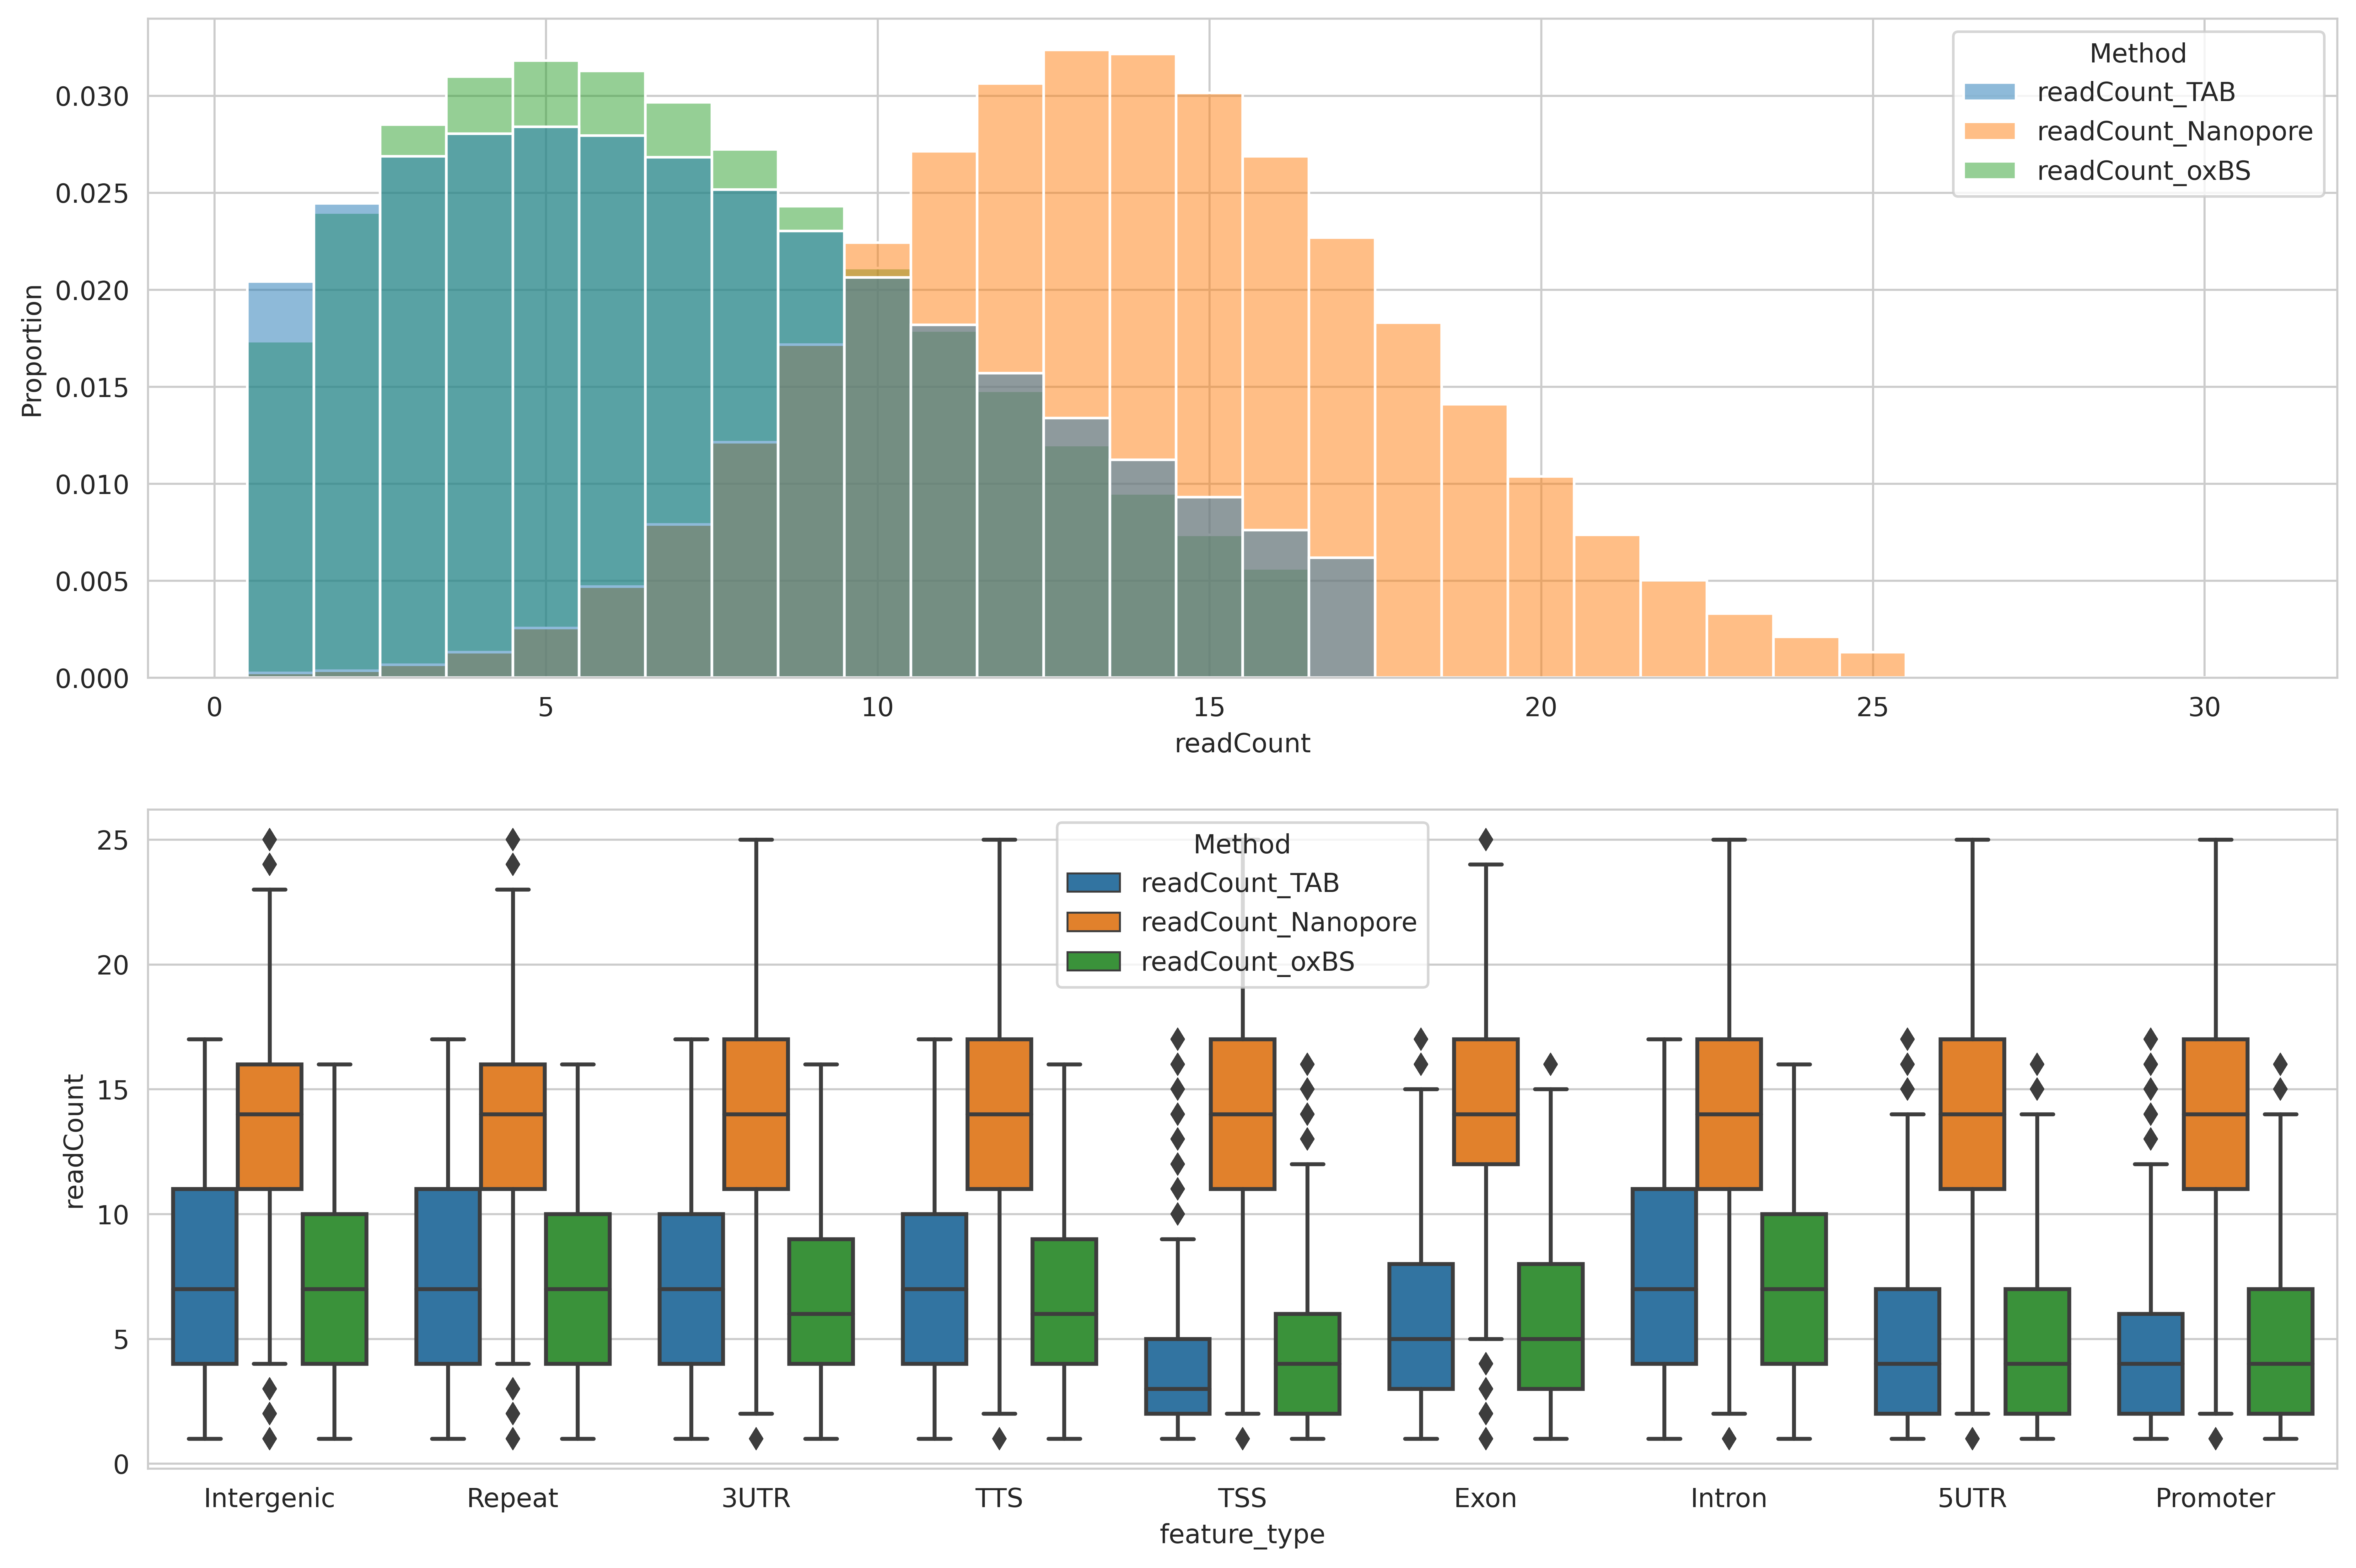

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_style("whitegrid")

fig, axes = plt.subplots(2, 1, figsize=(15, 10), dpi=600)

sns.histplot(readcount_features_df, x="readCount", stat="proportion", hue="Method", discrete=True, binwidth=1, binrange=(1, 30), ax=axes[0])
sns.boxplot(readcount_features_df, x="feature_type", y="readCount", hue="Method", dodge=True, ax=axes[1])

# CpG level comparison
## Similarities

In [2]:
import pandas as pd
prom_comp_data = pd.read_csv("intermediates/revised_01.08/prom_tab_oxBS_comparison_data.tsv", sep="\t")

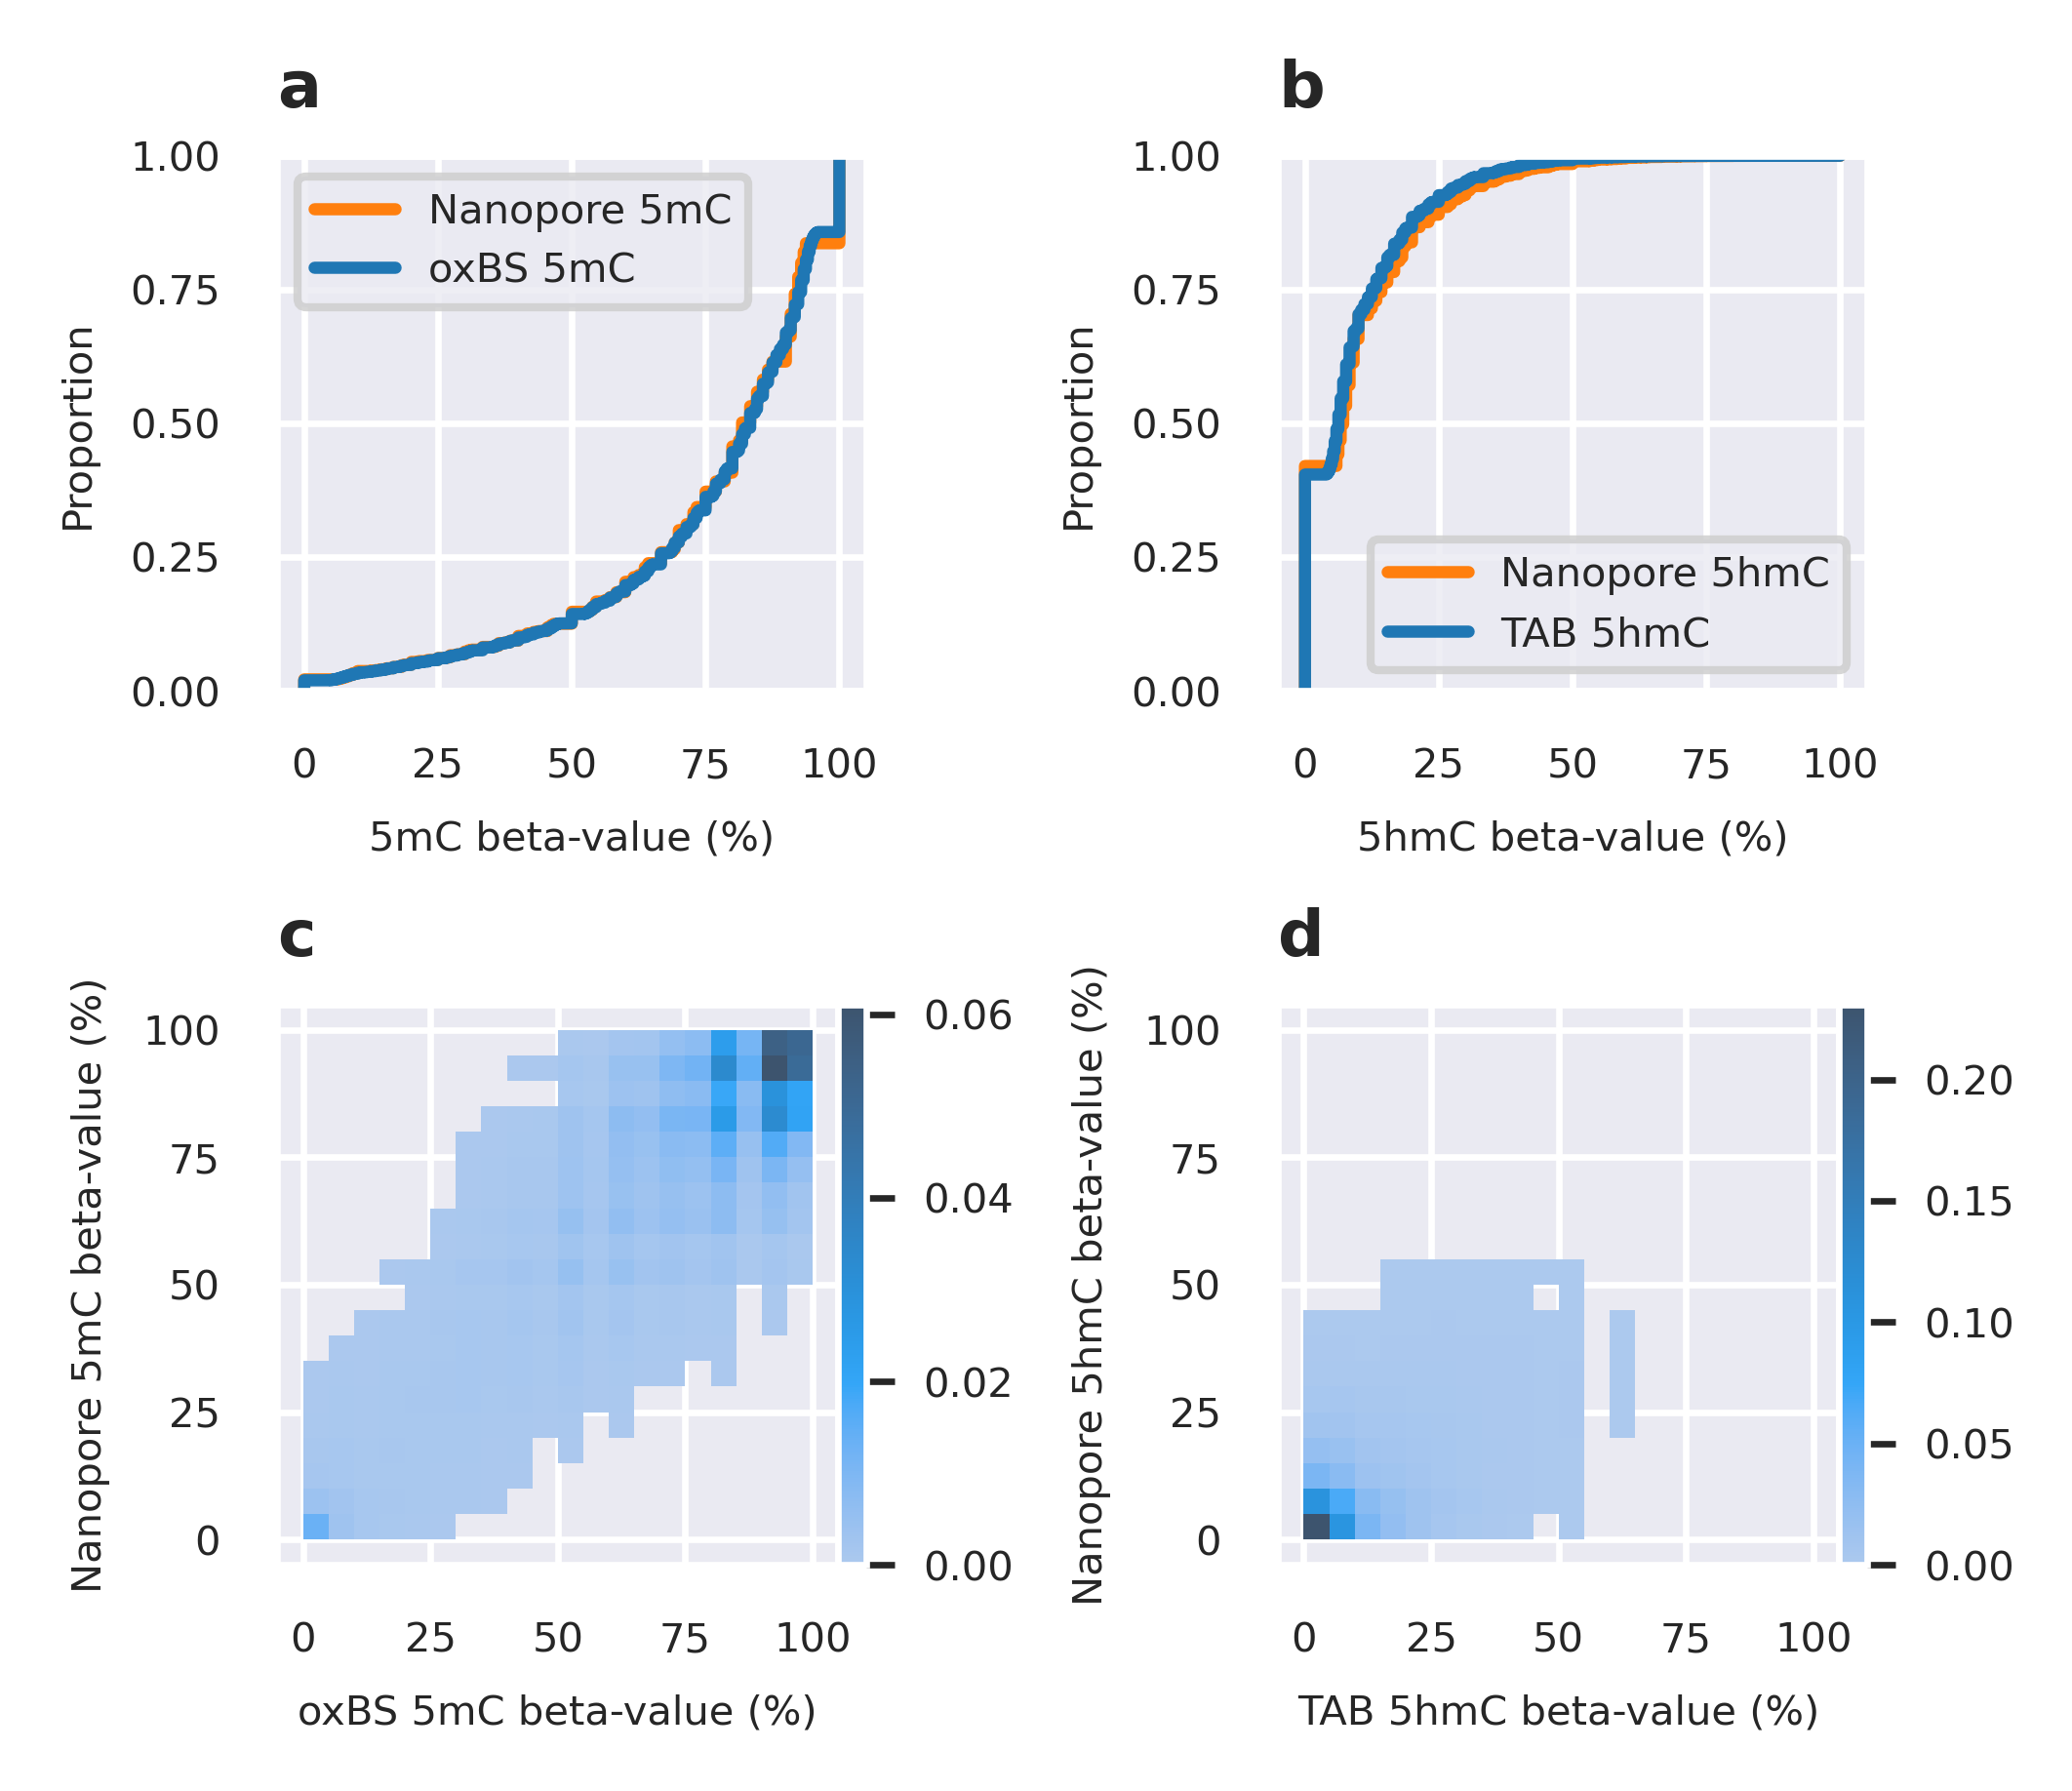

In [163]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

plt.figure(figsize=(89/25.4, 89/25.4), dpi=600)

sns.set_style("darkgrid")
mpl.rc('font', size=5)

ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax3 = plt.subplot2grid((2, 2), (1, 0))
ax4 = plt.subplot2grid((2, 2), (1, 1))

comparison = [["percentMeth_5mC_Prom", "percentMeth_5mC_Bisulphite"], ["percentMeth_5hmC_Prom", "percentMeth_5hmC_Bisulphite"]]
legends = [["Nanopore 5mC", "oxBS 5mC"], ["Nanopore 5hmC", "TAB 5hmC"]]

for index, ax in enumerate([ax1, ax2]):
    sns.ecdfplot(prom_comp_data.melt(
        id_vars=["chromosome", "chromStart", "chromEnd"], value_vars=comparison[index], var_name="method", value_name="percentMeth"),
    x="percentMeth", hue="method", ax=ax)
    ax.set_aspect(100)
    ax.set_xticks(np.arange(0, 125, 25))
    ax.set_yticks(np.arange(0, 1.25, 0.25))


ax1.set_xlabel("5mC beta-value (%)")
ax1.legend(labels=legends[0], title=None, loc="upper left")
ax1.set_title("a", loc="left", fontsize=8, fontweight="bold")

ax2.set_xlabel("5hmC beta-value (%)")
ax2.legend(labels=legends[1], title=None, loc="lower right")
ax2.set_title("b", loc="left", fontsize=8, fontweight="bold")

for index, ax in enumerate([ax3, ax4]):
    div = make_axes_locatable(ax)
    cax = div.append_axes("right", size="5%", pad=0)
    sns.histplot(prom_comp_data, x=comparison[index][1], y=comparison[index][0], stat="proportion", binwidth=5, pthresh=0.01, cbar=True, ax=ax, cbar_ax=cax)
    ax.set_aspect("equal")
    ax.set_yticks(np.arange(0, 125, 25))
    ax.set_xticks(np.arange(0, 125, 25))

ax3.set_xlabel("oxBS 5mC beta-value (%)")
ax3.set_ylabel("Nanopore 5mC beta-value (%)")
ax3.set_title("c", loc="left", fontsize=8, fontweight="bold")

ax4.set_xlabel("TAB 5hmC beta-value (%)")
ax4.set_ylabel("Nanopore 5hmC beta-value (%)")
ax4.set_title("d", loc="left", fontsize=8, fontweight="bold")

plt.gcf().set_size_inches(89/25.4, 89/25.4)
plt.subplots_adjust(wspace=0.7, hspace=0.2)
# plt.tight_layout()
plt.savefig("/u/n/doh28/Documents/Nanopore_HMC/Figures/CpG_level_sim.png", dpi=600)

In [105]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

comparison = [["percentMeth_5mC_Prom", "percentMeth_5mC_Bisulphite"], ["percentMeth_5hmC_Prom", "percentMeth_5hmC_Bisulphite"]]

for comp in comparison:
    x = prom_comp_data[comp[1]].to_numpy().reshape(-1, 1)
    y = prom_comp_data[comp[0]].to_numpy().reshape(-1, 1)

    model.fit(x, y)
    print(f"Model for {comp[0]} ~ {comp[1]}: {round(float(model.intercept_), 3)} + {round(float(model.coef_), 3)}X; R\N{SUPERSCRIPT TWO}={round(float(model.score(x, y)), 3)}")

Model for percentMeth_5mC_Prom ~ percentMeth_5mC_Bisulphite: 15.79 + 0.793X; R²=0.639
Model for percentMeth_5hmC_Prom ~ percentMeth_5hmC_Bisulphite: 4.422 + 0.435X; R²=0.241


## Differences

In [1]:
import pandas as pd
prom_comp_data = pd.read_csv("intermediates/revised_01.08/prom_tab_oxBS_comparison_data.tsv", sep="\t")

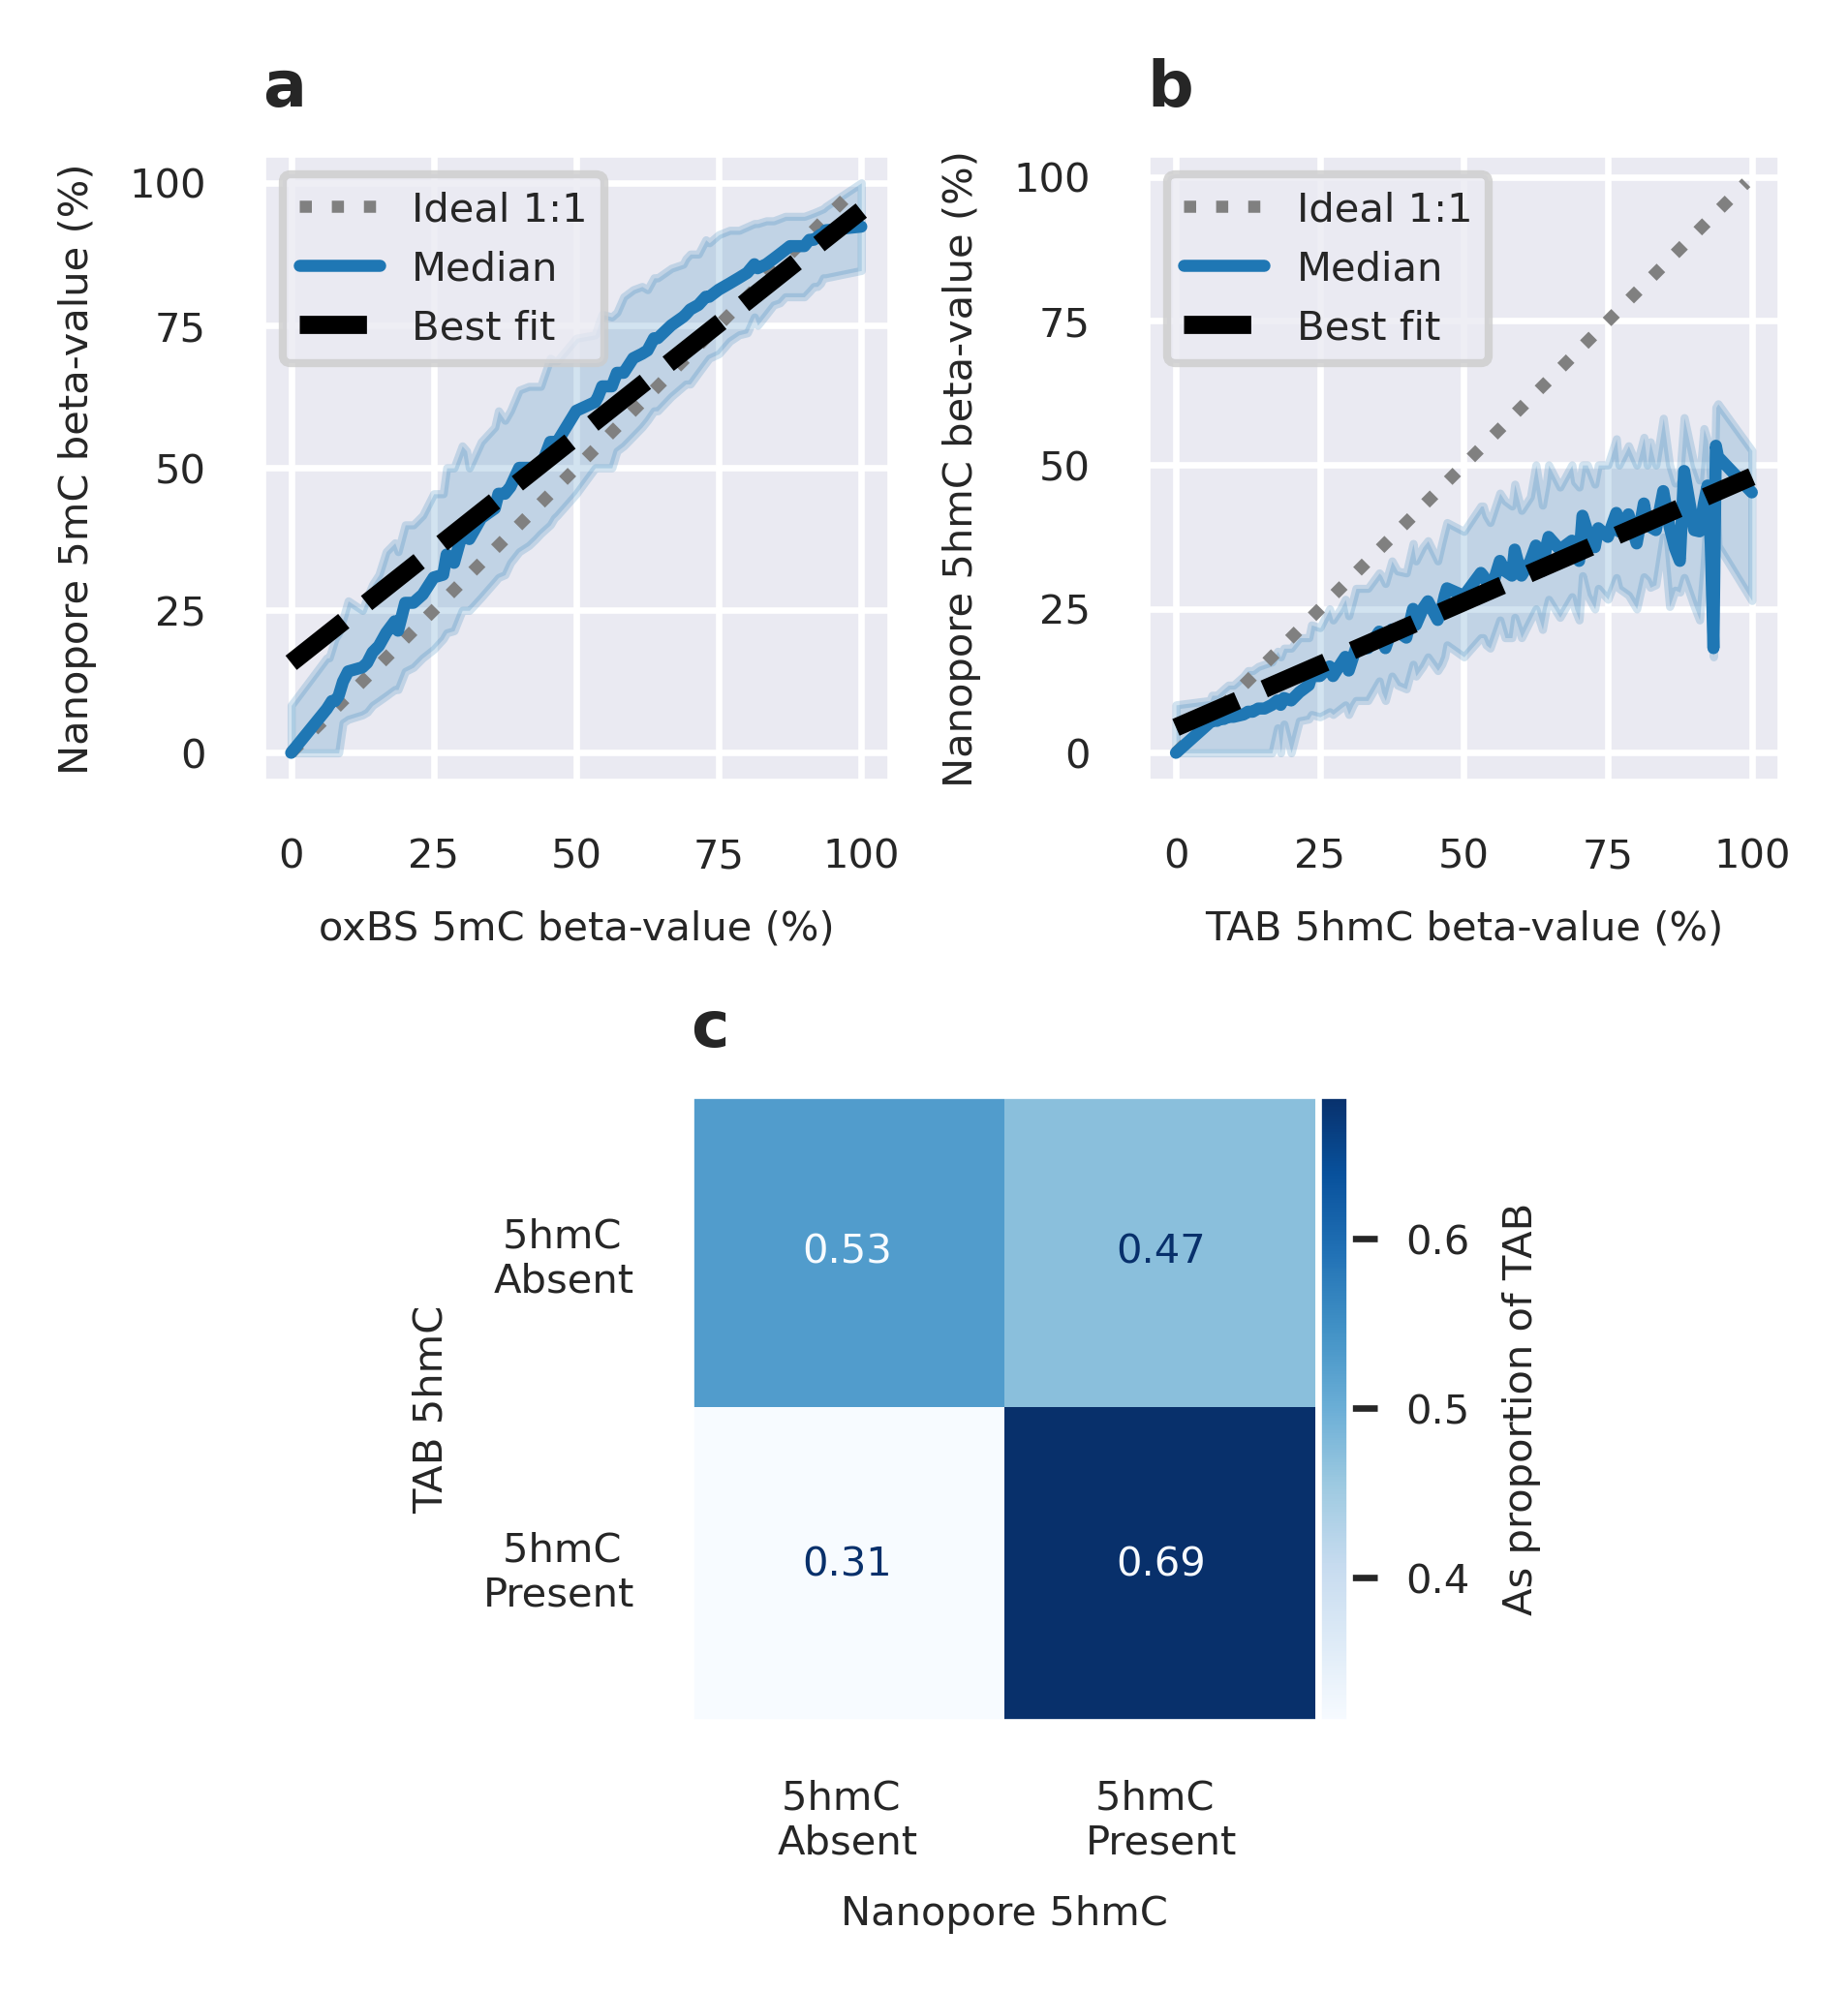

In [162]:
import seaborn as sns
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.preprocessing import Binarizer
from sklearn import metrics
from cycler import cycler

plt.figure(figsize=(89/25.4, 89/25.4), dpi=600)

sns.set_style("darkgrid")
mpl.rc('font', size=5)

ax1 = plt.subplot2grid((2, 4), (0, 0), colspan=2)
ax2 = plt.subplot2grid((2, 4), (0, 2), colspan=2)
ax3 = plt.subplot2grid((2, 4), (1, 1), colspan=2)

##### Row 1 #####
# Panel 1 and 2 # 

comparison = [["percentMeth_5mC_Prom", "percentMeth_5mC_Bisulphite"], ["percentMeth_5hmC_Prom", "percentMeth_5hmC_Bisulphite"]]

for index, ax in enumerate([ax1, ax2]):
    ax.plot(np.arange(0, 100, 1), np.arange(0, 100, 1), c="grey", ls=":", label="Ideal 1:1")
    sns.lineplot(prom_comp_data, x=comparison[index][1], y=comparison[index][0], label="Median", estimator='median', errorbar=("pi", 50), ax=ax)
    sns.regplot(prom_comp_data, x=comparison[index][1], y=comparison[index][0], ci=None, color="black", line_kws={"ls" : "--"}, label="Best fit", scatter=False, ax=ax)
    ax.set_aspect("equal")
    ax.set_xticks(np.arange(0, 125, 25))
    ax.set_yticks(np.arange(0, 125, 25))
    ax.legend()

ax1.set_xlabel("oxBS 5mC beta-value (%)")
ax1.set_ylabel("Nanopore 5mC beta-value (%)")
ax1.set_title("a", loc="left", fontsize=8, fontweight="bold")

ax2.set_xlabel("TAB 5hmC beta-value (%)")
ax2.set_ylabel("Nanopore 5hmC beta-value (%)")
ax2.set_title("b", loc="left", fontsize=8, fontweight="bold")

##### Row 2 #####
# Panel 3 # 

div = make_axes_locatable(ax3)
cax = div.append_axes("right", size="5%", pad=0)

true, pred = prom_comp_data["percentMeth_5hmC_Bisulphite"].to_numpy().reshape((-1, 1)), prom_comp_data["percentMeth_5hmC_Prom"].to_numpy().reshape((-1, 1))

binarizer = Binarizer(threshold=0)
true_b, pred_b = binarizer.fit_transform(true), binarizer.fit_transform(pred)
cm = metrics.ConfusionMatrixDisplay.from_predictions(
    true_b, pred_b, 
    display_labels=["5hmC \nAbsent", "5hmC \nPresent"], 
    normalize="true", 
    colorbar=False, cmap="Blues", 
    im_kw={"origin" : "lower"}, 
    values_format=".2f",
    ax=ax3)

plt.colorbar(cm.im_, cax, label="As proportion of TAB")
ax3.grid(False)
ax3.set_xlabel("Nanopore 5hmC")
ax3.set_ylabel("TAB 5hmC")
ax3.set_title("c", loc="left", fontsize=8, fontweight="bold")

plt.gcf().set_size_inches(89/25.4, 89/25.4)
plt.subplots_adjust(wspace=0.8, hspace=0.5)
# plt.tight_layout()
plt.savefig("/u/n/doh28/Documents/Nanopore_HMC/Figures/CpG_level_dif.png", dpi=600)

In [ ]:
# Panel 4 # 

c_cycler = cycler(color=sns.color_palette("Dark2", 4))
ax4.set_prop_cycle(c_cycler)
for value in [0, 10, 25, 50]:
    binarizer = Binarizer(threshold=value) 
    true_b = binarizer.fit_transform(true)
    # print(metrics.roc_auc_score(true_b, pred))
    metrics.PrecisionRecallDisplay.from_predictions(true_b, pred, label=f"{value}%",  ax=ax4)

ax4.set_xticks(np.arange(0, 1.25, 0.25))
ax4.set_yticks(np.arange(0, 1.25, 0.25))
ax4.set_aspect("equal")
ax4.set_title("d", loc="left", fontsize=8, fontweight="bold")

# Macro-level 5hmC comparison

In [ ]:
import pandas as pd
prom_comp_data = pd.read_csv("intermediates/revised_01.08/prom_tab_oxBS_comparison_data.tsv", sep="\t")

In [ ]:
import pandas as pd

hmc_df_wide = pd.read_csv("./intermediates/hmc_df_wide.tsv", sep="\t", names=["Chromosome", "Start", "End", "strand", "readCount_Nanopore", "percentMeth_Nanopore_5hmC", "readCount_TAB", "percentMeth_Bisulphite_5hmC"]).drop(columns=["readCount_Nanopore", "readCount_TAB"])

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from Checkpoints import Checkpoint
from mpl_toolkits.axes_grid1 import make_axes_locatable
from GroupCpGs import *
import numpy as np

In [ ]:
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("Paired")[2:4])

fig5 = plt.figure(figsize=(10, 12), dpi=600)
gs5 = GridSpec(3, 2, fig5, height_ratios=(2, 2, 3))

##### ax0 ##### 

ax0 = fig5.add_subplot(gs5[0, :2])

group_df_feature = FeatureAndGene(CpGIntersects(hmc_df_wide).group("features")).asLongDf()
sns.violinplot(group_df_feature, x="feature_type", y="percentMeth", hue="method", split=False, ax=ax0)
ax0.set_title("A", loc="left")
ax0.set_ylim(0, 50)
ax0.set_xlabel("Genomic feature")
ax0.set_ylabel("Average CpG 5hmC \u03B2$_{\%}$")
sns.move_legend(ax0, "upper left", title=None)

##### ax1 ##### 

ax1 = fig5.add_subplot(gs5[1, :2])

group_df_cgi = FeatureAndGene(CpGIntersects(hmc_df_wide).group("CGI")).asLongDf()
sns.violinplot(group_df_cgi, x="feature_type", y="percentMeth", hue="method", split=False, ax=ax1)
ax1.set_title("B", loc="left")
ax1.set_ylim(0, 50)
ax1.set_xlabel("Position relative to CGI")
ax1.set_ylabel("Average CpG 5hmC \u03B2$_{\%}$")
sns.move_legend(ax1, "upper left", title=None)

##### ax20 #####

ax20 = fig5.add_subplot(gs5[2, 0])
gene_data = FeatureAndGene(CpGIntersects(hmc_df_wide).group("genes"), 10)
div20 = make_axes_locatable(ax20)
cax20 = div20.append_axes("right", size="5%", pad=0.05)

gene_data.makeHist("density", ax20, cax20)

ax20.set_title("C", loc="left")

##### ax21 ##### 

ax21 = fig5.add_subplot(gs5[2, 1])
tile_data = tiledGroup(CpGIntersects(hmc_df_wide).groupByGenomicWindow(300), 10)
div21 = make_axes_locatable(ax21)
cax21 = div21.append_axes("right", size="5%", pad=0.05)

tile_data.makeHist("density", ax21, cax21)

##### ax formatting #####

for ax in [ax20, ax21]:
    ax.set_aspect("equal")
    ax.plot(np.arange(-5.5, 4, 1), np.arange(-5.5, 4, 1), color="black", linestyle=":")
    ax.set_ylim((-5.5, 3))
    ax.set_xlim((-5.5, 3))
    ax.set_xlabel("TAB enrichment")
    ax.set_ylabel("Nanopore enrichment")

ax21.set_title("D", loc="left")

##### Outputs #####

fig5.tight_layout()
fig5.savefig('/u/n/doh28/Documents/Nanopore_HMC/Figures/Figure5.png')
plt.close()